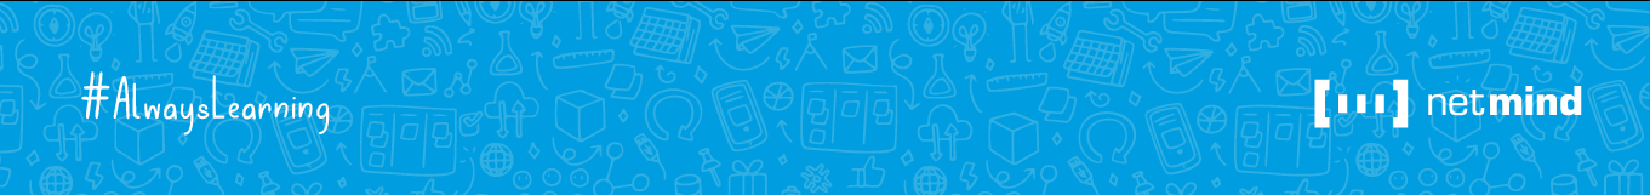
# **Definir y usar componentes**

Un componente en Azure Machine Learning es un bloque reutilizable que encapsula una tarea específica, como preprocesamiento de datos, entrenamiento de modelos o evaluación. 

Con el SDK v2 (azure.ai.ml), puedes definir y registrar componentes de manera programática para utilizarlos en pipelines y otros flujos de trabajo.

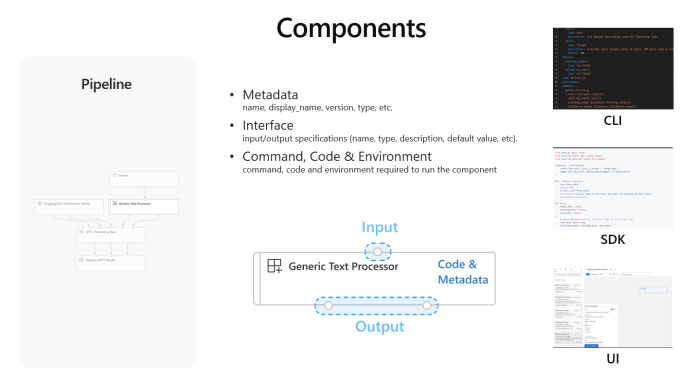

https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-component-pipeline-python?spm=a2ty_o01.29997173.0.0.5a68c9219tjYuy

## **Componentes**
Los componentes permiten crear scripts reutilizables que se pueden compartir fácilmente entre los usuarios dentro del mismo área de trabajo de Azure Machine Learning. 

Hay dos razones principales por las que usaría componentes:
- Para compilar un pipeline.
- Para compartir código.


**Querremos crear componentes al preparar nuestro código para escalabilidad:** Cuando hayamos terminado de experimentar y desarrollar, y estemos listos para llevar el modelo a producción.

- En Azure Machine Learning, puede crear un componente para almacenar código (en el lenguaje preferido) dentro del área de trabajo. 
- Lo ideal es diseñar un componente para realizar una acción específica que sea pertinente en el flujo de trabajo de ML.
    - Por ejemplo, un componente puede constar de un script de Python que normaliza los datos, entrena un modelo de aprendizaje automático o evalúa un modelo.
    - Los componentes se pueden compartir fácilmente con otros usuarios de Azure Machine Learning, que pueden reutilizar componentes en sus propias canalizaciones de Azure Machine Learning.

### Conceptos clave

- **Componente**: Un componente encapsula código (scripts Python, comandos, etc.) junto con sus entradas, salidas y entorno de ejecución.
- **Entradas** y Salidas: Los componentes pueden aceptar datos como entrada (por ejemplo, datasets) y producir artefactos como salida (por ejemplo, modelos entrenados).
- **Entorno**: Define las dependencias necesarias para ejecutar el componente, como bibliotecas de Python o imágenes Docker personalizadas.
- **Registro**: Una vez definido, el componente debe registrarse en el Workspace de Azure ML para ser reutilizado en pipelines.


> Más información: 
- https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-inputs-outputs-pipeline?view=azureml-api-2&tabs=cli
- https://learn.microsoft.com/en-us/python/api/azure-ai-ml/azure.ai.ml?view=azure-python


## **Definir un componente**

Se puedes definir un componente de varias maneras:

- Desde un Script Python: Si tienes un script que realiza una tarea específica, puedes encapsularlo en un componente.
- Desde un Archivo YAML: Puedes definir el componente en un archivo YAML para mayor claridad y modularidad.

## **Crear un componente usando un script de python**
Simplemente es un command que encapsula el script correspondiente.

In [ ]:
preprocesar_datos = command(
    name="preprocesar_datos",  # Nombre del componente
    display_name="Preprocesamiento de Datos",  # Nombre descriptivo
    description="Un componente que limpia y transforma datos.",
    code="./src",  # Carpeta que contiene el script
    command="python preprocess.py --input_data ${{inputs.raw_data}} --output_data ${{outputs.processed_data}}",
    inputs={
        "raw_data": {"type": "uri_folder", "description": "Datos sin procesar"},
    },
    outputs={
        "processed_data": {"type": "uri_folder", "description": "Datos procesados"},
    },
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",  # Entorno de ejecución
)

## **Crear un componente usando Yaml**
Un componente consta de tres partes:

- **Metadatos**: incluye el nombre, la versión, etc. del componente.
- **Interfaz**: incluye los parámetros de entrada esperados (como un conjunto de datos o hiperparámetros) y la salida esperada (como métricas y artefactos).
- **Comando, código y entorno**: especifica cómo ejecutar el código.

Para crear un componente, se necesitan dos archivos:

- Script que contiene el flujo de trabajo que desea ejecutar.
- Un archivo YAML para definir los metadatos, la interfaz y el comando, el código y el entorno del componente.

Se puede crear el archivo YAML o usar la función command_component() como decorador para crear el archivo YAML.

**Ejemplo:**  script de Python `prep.py` que prepara los datos quitando los valores que faltan y normalizando los datos:

In [ ]:
# import libraries
import argparse
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

# setup arg parser
parser = argparse.ArgumentParser()

# add arguments
parser.add_argument("--input_data", dest='input_data',
                    type=str)
parser.add_argument("--output_data", dest='output_data',
                    type=str)

# parse args
args = parser.parse_args()

# read the data
df = pd.read_csv(args.input_data)

# remove missing values
df = df.dropna()

# normalize the data    
scaler = MinMaxScaler()
num_cols = ['feature1','feature2','feature3','feature4']
df[num_cols] = scaler.fit_transform(df[num_cols])

# save the data as a csv
output_df = df.to_csv(
    (Path(args.output_data) / "prepped-data.csv"), 
    index = False
)

El descriptor YAML para el script (`prep.yml`):

```yaml
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
name: prep_data
display_name: Prepare training data
version: 1
type: command
inputs:
  input_data: 
    type: uri_file
outputs:
  output_data:
    type: uri_file
code: ./src
environment: azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest
command: >-
  python prep.py 
  --input_data ${{inputs.input_data}}
  --output_data ${{outputs.output_data}}
```

## **Cargar el componente:**

- Desde su definicipon de yaml

In [ ]:
from azure.ai.ml import load_component
parent_dir = ""

loaded_component_prep = load_component(source=parent_dir + "./prep.yml")

- Existente en el workspace

In [ ]:
# Obtener un componente por nombre y versión
component_name = "ws_componente"
component_version = "1"

component = ml_client.components.get(name=component_name, version=component_version)
print(f"Componente cargado: {component.name}, Versión: {component.version}")

## **Registro de un componente**
Para usar componentes en una pipeline, necesitaremos el script y YAML. 

Para que los componentes sean accesibles para otros usuarios del área de trabajo, también se deben registrar.

In [ ]:
prep = ml_client.components.create_or_update(prepare_data_component)

## **Usar un componente**

Después de registrar el componente, puede ser usado en pipelines.

In [ ]:
# Definir un pipeline que use el componente cargado
@pipeline()
def mi_pipeline(input_data):
    paso_componente = component(input_data=input_data)
    return {
        "output": paso_componente.outputs.output_data,
    }

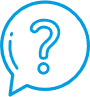
## **¿Preguntas?**

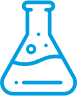
## **Lab 4**

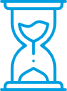
## **Ejercicio**

Usando el dataset de precios de casas (data/house_price/data.csv):
- Define componentes para: la ingesta y preprocesamiento de datos; Entrenamiento; y Evaluación de un modelo.
- Registra los componentes en el workspace.
- Bonus: en componente de evaluación, evalúa y registra las curvas de validación y de aprendizaje.